In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import tensorflow as tf
import seaborn as sns
from IPython.display import Audio, display
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Resizing, Input, Normalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.math import confusion_matrix

## EDA

In [2]:
data = pd.read_csv('torgo_data/data.csv')
data.head()

,is_dysarthria,gender,filename
0,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
1,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
2,non_dysarthria,female,torgo_data/non_dysarthria_female/FC02_Session3...
3,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...
4,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session1...


### Get sample audio for each class

In [3]:
data.sample(frac=1).reset_index(drop=True, inplace=True)
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_non_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_non_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
sample_data = pd.concat([male_dysarthric, female_dysarthric, male_non_dysarthric, female_non_dysarthric])
sample_data

,is_dysarthria,gender,filename
1733,dysarthria,male,torgo_data/dysarthria_male/M03_Session2_0110.wav
984,dysarthria,female,torgo_data/dysarthria_female/F01_Session1_0129...
1462,non_dysarthria,male,torgo_data/non_dysarthria_male/MC03_Session2_0...
362,non_dysarthria,female,torgo_data/non_dysarthria_female/FC03_Session2...


In [4]:
rows = 2
cols = 2
n = rows * cols

### Plot Waveform

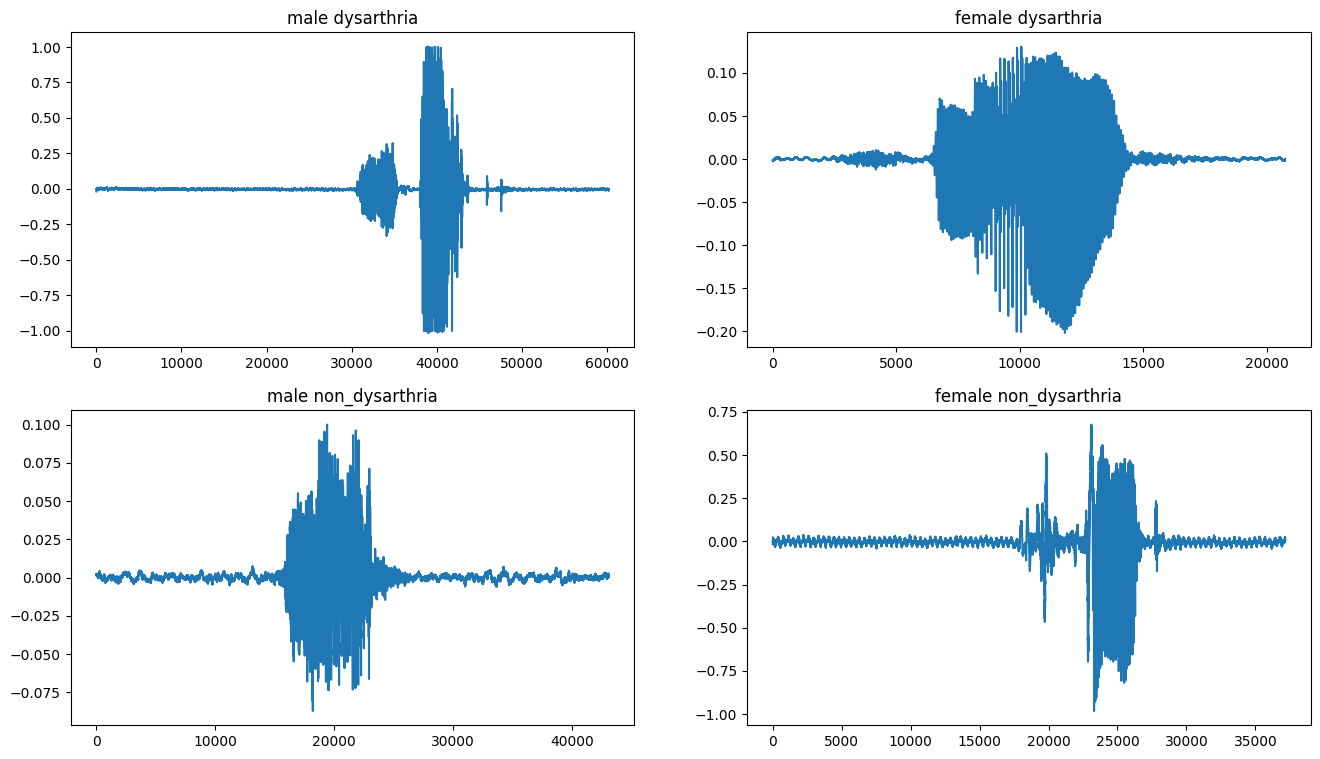

In [5]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    
    sample = sample_data.iloc[i]

    audio, sr = librosa.load(sample.filename)
    ax.plot(audio)
    ax.set_title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

### Spectrogram

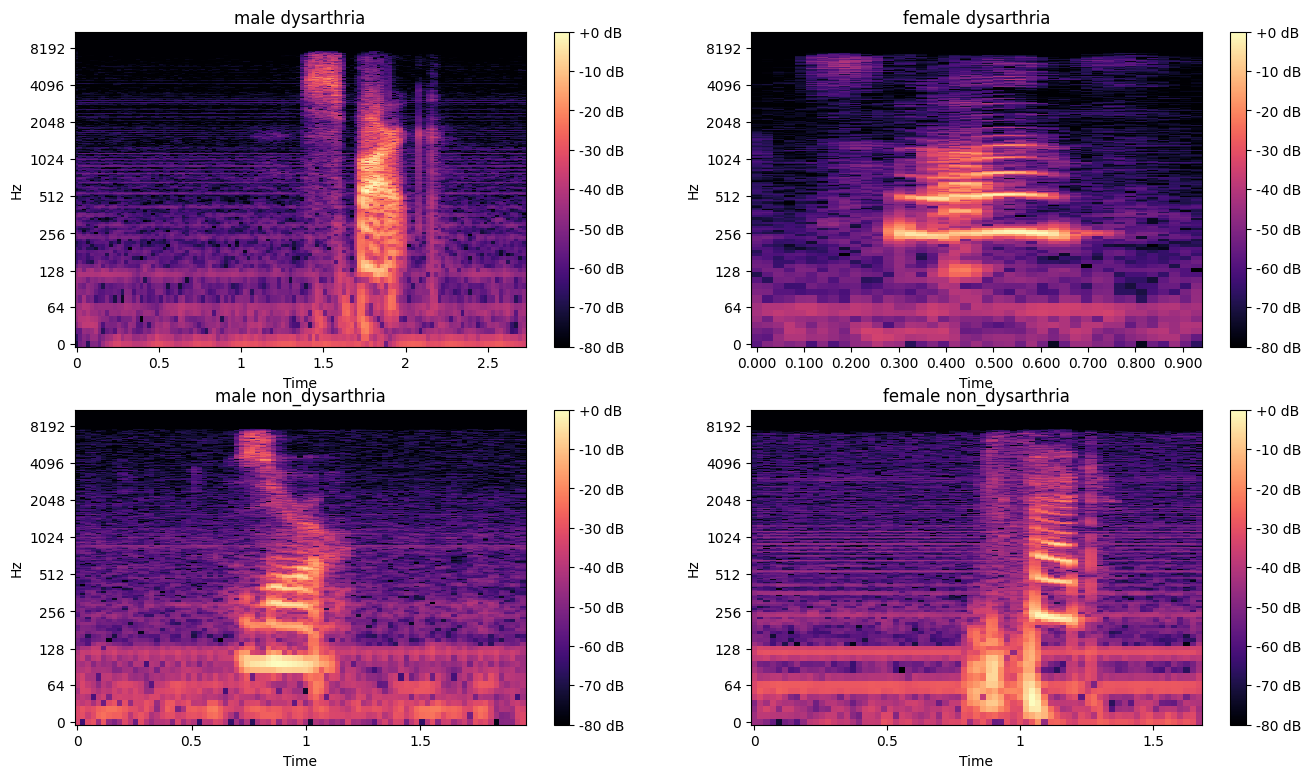

In [6]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    sample = sample_data.iloc[i]
    audio, sr = librosa.load(sample.filename)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    plt.subplot(rows, cols, i + 1) 
    librosa.display.specshow(spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

### Mel Frequency Cepstral Coefficients (MFCC)

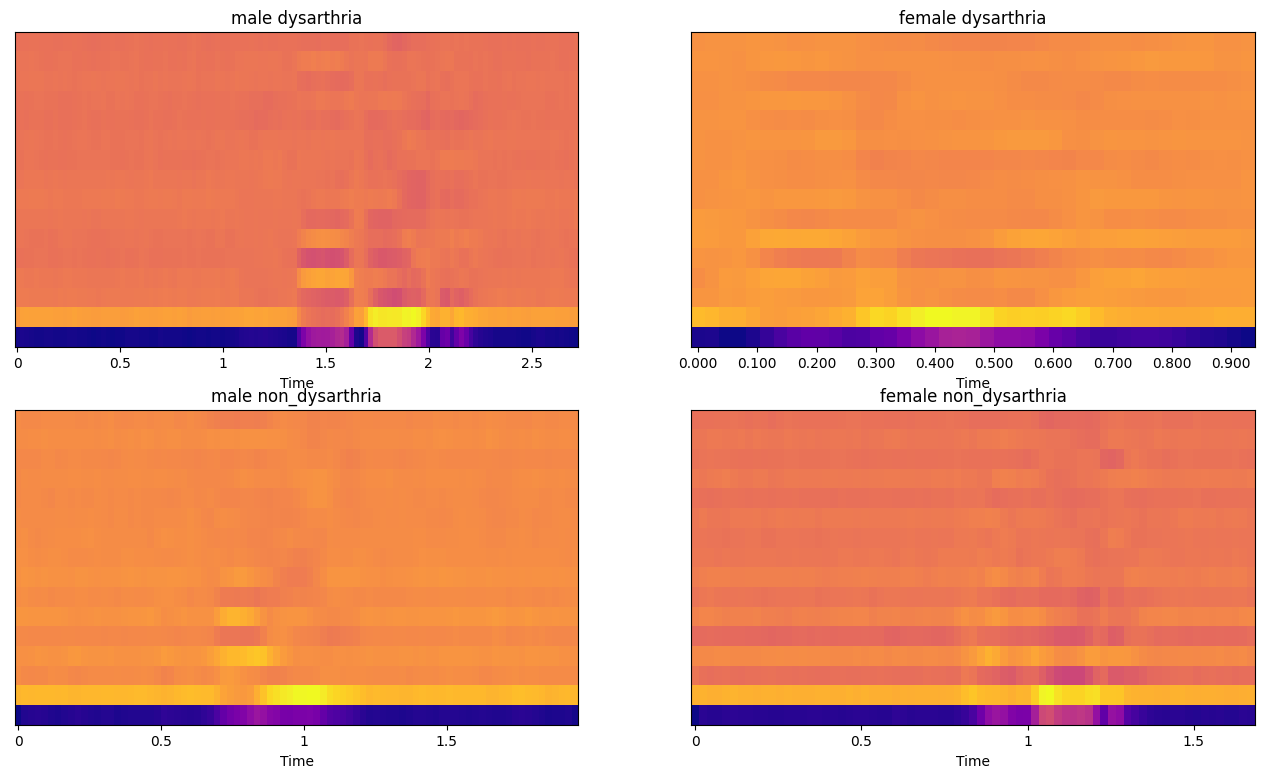

In [7]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    sample = sample_data.iloc[i]
    audio, sr = librosa.load(sample.filename)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=16, hop_length=512)
    plt.subplot(rows, cols, i + 1) 
    librosa.display.specshow(mfcc, x_axis='time', cmap='plasma')
    plt.title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

### Spectral Rolloff

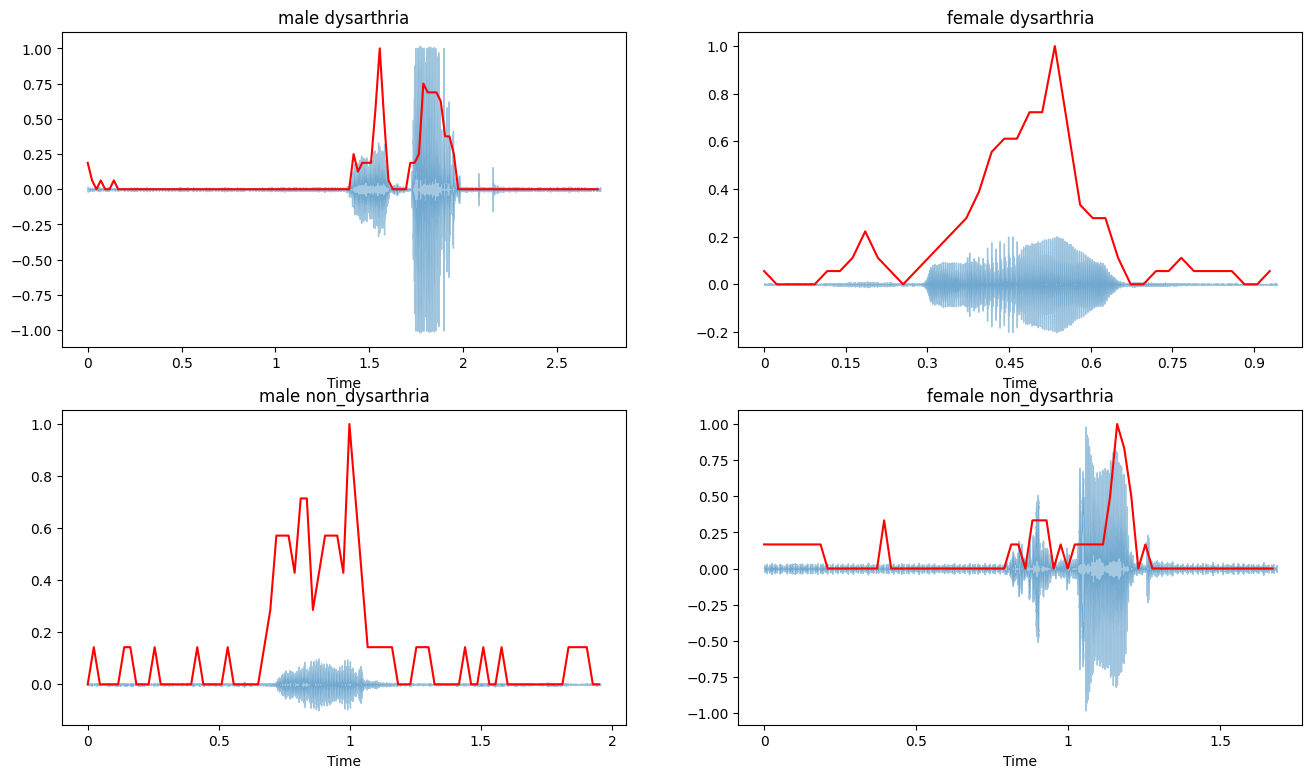

In [8]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    sample = sample_data.iloc[i]
    audio, sr = librosa.load(sample.filename)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.01)[0]
    plt.subplot(rows, cols, i + 1) 
    t = librosa.frames_to_time(range(len(spectral_rolloff)))
    spectral_rolloff = minmax_scale(spectral_rolloff, axis=0)
    librosa.display.waveshow(audio, sr=sr, alpha=0.4)
    plt.plot(t, spectral_rolloff, color='r')
    plt.title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

### Zero Crossing Rate

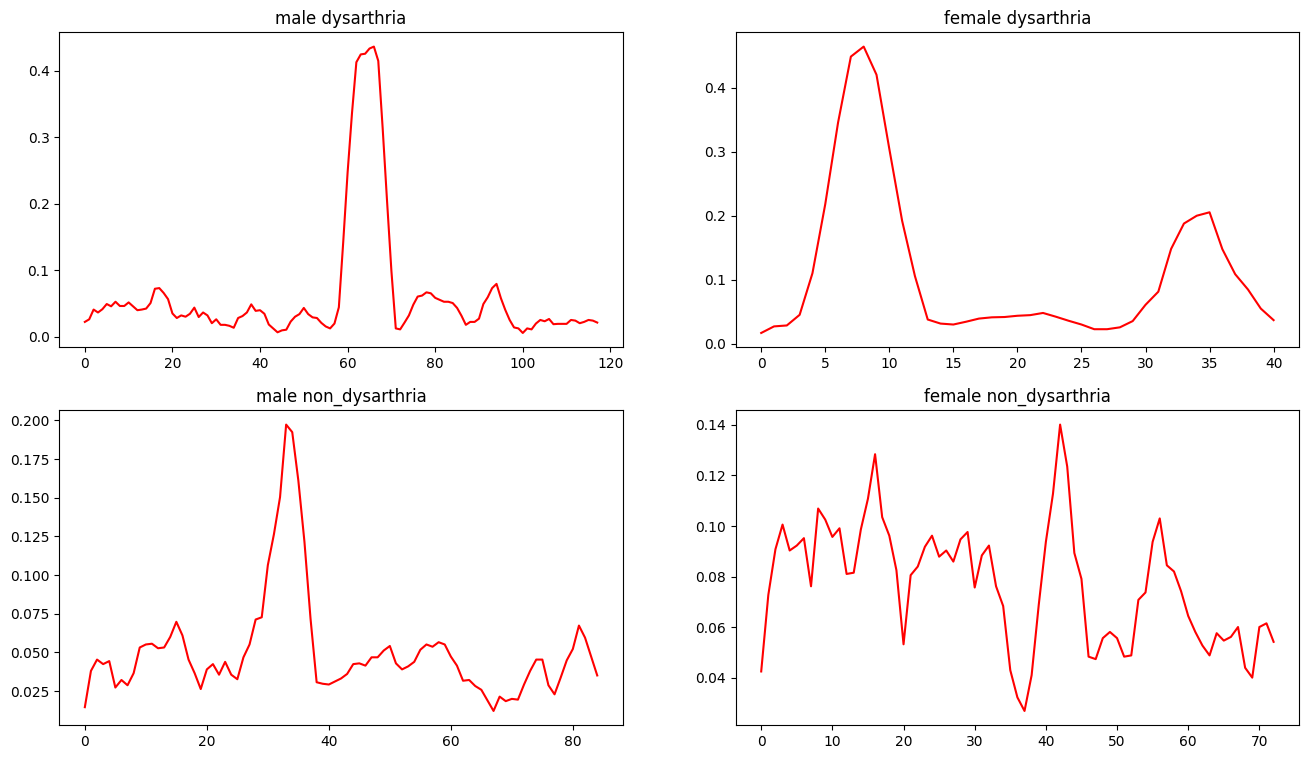

In [9]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i >= n: break
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    sample = sample_data.iloc[i]
    audio, sr = librosa.load(sample.filename)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    plt.subplot(rows, cols, i + 1) 
    plt.plot(zero_crossing_rate, color='r')
    plt.title(f'{sample.gender} {sample.is_dysarthria}')

plt.show()

## Preprocessing

### Removing broken audios

In [10]:
def check_audio(row):
    try:
        audio, sr = librosa.load(row.filename)
        return True
    except Exception as e:
        print(f"Error processing {row.filename}: {e}")
        return False

valid = data.apply(check_audio, axis=1)
data = data[valid]
data.reset_index(drop=True, inplace=True)
data.shape

C:\Users\Dilon\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing torgo_data/dysarthria_female/F01_Session1_0068.wav: 


(1999, 3)

### Extract Spectrogram (not used)

In [11]:
def get_spectrogram(row):
    try:
        audio, sr = librosa.load(row.filename)
        spectrogram = np.mean(librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max), axis=1)
        return spectrogram
    except Exception as e:
        print(f"Error processing {row.filename}: {e}")
        return [np.nan]  

### Extract MFCC

In [12]:
def get_mfcc(row):
    try:
        audio, sr = librosa.load(row['filename'])
        mean_mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=128), axis=1)
        return mean_mfcc
    except Exception as e:
        print(f"Error processing {row.filename}: {e}")
        return [np.nan]  

In [13]:
features = data.apply(get_spectrogram, axis=1)
spectrogram_data = pd.DataFrame(features.tolist(), index=data.index)
spectrogram_data['is_dysarthria'] = data['is_dysarthria']
spectrogram_data.head()

c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:258: UserWarning: n_fft=2048 is too large for input signal of length=209
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:258: UserWarning: n_fft=2048 is too large for input signal of length=583
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:258: UserWarning: n_fft=2048 is too large for input signal of length=581
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:258: UserWarning: n_fft=2048 is too large for input signal of length=185
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Dilon\AppData\Local

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,1024,is_dysarthria
0,-39.238750,-40.463120,-42.277172,-44.379898,-45.978317,-36.252445,-35.613083,-45.898674,-54.794632,-54.180164,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,non_dysarthria
1,-31.083071,-35.751961,-38.833050,-39.866581,-39.902515,-27.496754,-26.721334,-38.664524,-50.349777,-51.026951,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,non_dysarthria
2,-28.217615,-32.723259,-38.044949,-39.237644,-38.722775,-24.634132,-23.852884,-35.760487,-47.969711,-47.174690,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,non_dysarthria
3,-33.824608,-37.624954,-41.077782,-41.392467,-42.248272,-30.873032,-30.157541,-41.507393,-48.930256,-48.312256,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,non_dysarthria
4,-35.774178,-39.322540,-41.459560,-41.921074,-41.727589,-30.546545,-29.653656,-41.206806,-51.832443,-50.869827,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,non_dysarthria


In [14]:
features = data.apply(get_mfcc, axis=1)
mfcc_data = pd.DataFrame(features.tolist(), index=data.index)
mfcc_data['is_dysarthria'] = data['is_dysarthria']
mfcc_data.head()

c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:258: UserWarning: n_fft=2048 is too large for input signal of length=209
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:258: UserWarning: n_fft=2048 is too large for input signal of length=583
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:258: UserWarning: n_fft=2048 is too large for input signal of length=581
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:258: UserWarning: n_fft=2048 is too large for input signal of length=185
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Dilon\AppData\Local

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,is_dysarthria
0,-221.788269,101.259232,-16.548130,38.492065,-13.595653,20.772554,-5.536350,10.410691,1.962461,-0.799047,...,0.962193,0.744855,1.058080,0.388452,0.081758,0.546173,0.594357,0.170033,-0.219215,non_dysarthria
1,-299.520050,109.872574,-17.097269,38.854965,-16.881128,22.959133,1.824229,18.724186,3.448542,4.455821,...,1.105589,1.056284,1.252576,0.027334,-1.368950,-0.037858,0.020661,-0.082124,-0.744832,non_dysarthria
2,-302.950043,112.048477,-23.679884,44.887421,-22.434727,26.299335,0.811477,18.210293,4.344697,4.912156,...,0.844332,0.530004,1.018391,0.055385,-1.472087,0.295324,0.191228,-0.224301,-0.582725,non_dysarthria
3,-210.861603,116.504486,-35.046497,37.670425,-27.112514,25.593727,-7.511986,13.140749,-0.587346,4.138087,...,0.630752,0.898457,0.721398,0.174576,-0.090706,0.001523,0.360465,-0.075449,-0.259715,non_dysarthria
4,-280.227203,104.505035,-17.209875,45.064884,-15.542122,28.115068,-3.449209,16.841440,4.573241,1.738297,...,1.596206,0.970084,0.732016,0.547593,-0.152663,0.131892,-0.288227,-0.468570,-0.461726,non_dysarthria


### Standardize MFCC with RobustScaler

In [15]:
mfcc_data["is_dysarthria"] = LabelEncoder().fit_transform(mfcc_data["is_dysarthria"])
X = mfcc_data.iloc[:,:-1].values
y = mfcc_data['is_dysarthria']

X = RobustScaler().fit_transform(X)

### Train (70%), Test (15%), Validation (15%) split

In [16]:
x_train, x_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test1, y_test1, test_size=0.5, random_state=42)

In [17]:
x_train = x_train.reshape(-1,16,8,1)
x_val = x_val.reshape(-1,16,8,1)
x_test = x_test.reshape(-1,16,8,1)

In [18]:
input_shape = x_train.shape[1:]

### Modelling

In [19]:
model = Sequential([
    InputLayer(input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(2, 2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                1

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.15),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [21]:
earlyStopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 2, verbose = 1, restore_best_weights=True)

In [22]:
EPOCHS = 10
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=earlyStopping)

Epoch 1/10


c:\Users\Dilon\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


44/44 [==============================] - 2s 18ms/step - loss: 0.5537 - accuracy: 0.7241 - val_loss: 0.4252 - val_accuracy: 0.7933
Epoch 2/10
44/44 [==============================] - 0s 6ms/step - loss: 0.3816 - accuracy: 0.8256 - val_loss: 0.3649 - val_accuracy: 0.8400
Epoch 3/10
44/44 [==============================] - 0s 7ms/step - loss: 0.2309 - accuracy: 0.9107 - val_loss: 0.1552 - val_accuracy: 0.9400
Epoch 4/10
44/44 [==============================] - 0s 6ms/step - loss: 0.1813 - accuracy: 0.9350 - val_loss: 0.2376 - val_accuracy: 0.9367
Epoch 5/10
44/44 [==============================] - 0s 7ms/step - loss: 0.1171 - accuracy: 0.9635 - val_loss: 0.0902 - val_accuracy: 0.9667
Epoch 6/10
44/44 [==============================] - 0s 7ms/step - loss: 0.0347 - accuracy: 0.9929 - val_loss: 0.0945 - val_accuracy: 0.9567
Epoch 7/10
44/44 [==============================] - 0s 8ms/step - loss: 0.0227 - accuracy: 0.9957 - val_loss: 0.0953 - val_accuracy: 0.9833
Epoch 7: early stopping


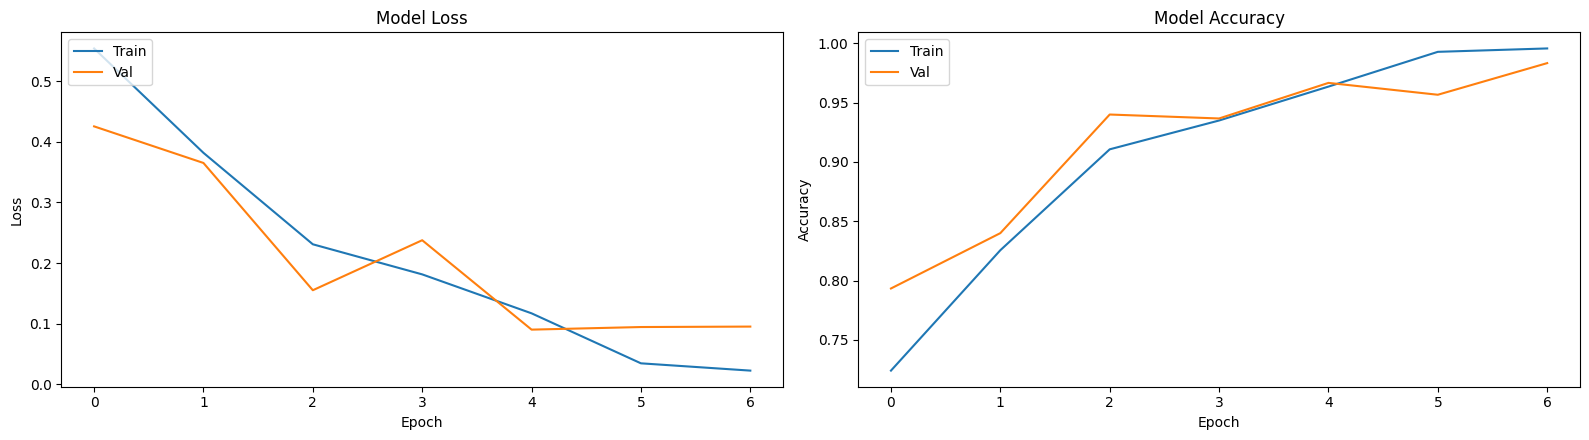

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='upper left')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

### Predicting Testing Set

In [24]:
y_pred = model.predict(x_test)

10/10 [==============================] - 0s 3ms/step


In [25]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

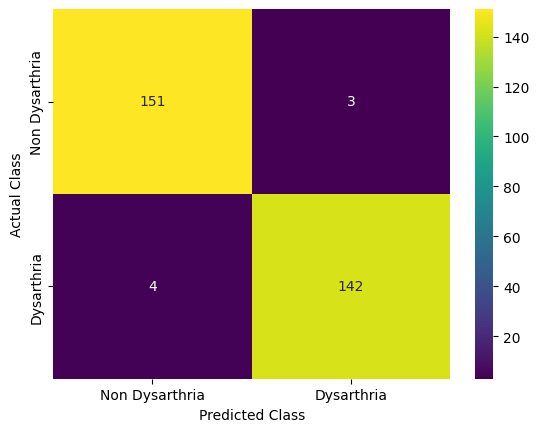

In [26]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.3g',xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       154
           1       0.98      0.97      0.98       146

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



## Testing on new Data

In [28]:
test_data = pd.read_csv('testing_data/data.csv')
test_data

,is_dysarthria,filename
0,non_dysarthria,testing_data/001.wav
1,dysarthria,testing_data/002.wav
2,dysarthria,testing_data/003.wav


### Get MFCC for the new data

In [29]:
test_features = test_data.apply(get_mfcc, axis=1)
test_mfcc = pd.DataFrame(test_features.tolist(), index=test_data.index)
test_mfcc['is_dysarthria'] = test_data['is_dysarthria']
test_mfcc["is_dysarthria"] = LabelEncoder().fit_transform(test_mfcc["is_dysarthria"])
test_mfcc.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,is_dysarthria
0,-318.893066,76.297707,-46.067303,27.522827,-29.502922,20.568413,-33.269653,9.075608,-19.336828,-0.110917,...,0.663722,-0.106383,-0.145479,-0.22383,0.990323,-0.439343,-0.501632,-0.344858,0.353537,1
1,-336.003632,57.527988,-13.724583,16.384026,-32.386097,24.186470,-17.020247,10.532653,-6.614578,1.063358,...,1.716760,0.692090,0.423386,-0.86033,1.675194,0.024876,0.087185,-0.309499,1.131087,0
2,-447.506958,145.912628,-1.650035,4.883324,8.621211,-21.212669,-7.169620,-3.348120,-12.841688,2.696570,...,0.084459,-0.269792,0.075430,0.31150,0.001142,0.178189,0.219749,0.058403,0.237551,0


In [30]:
testing_x = test_mfcc.iloc[:,:-1].values
testing_y = test_mfcc['is_dysarthria']

testing_x = RobustScaler().fit_transform(testing_x)

print(testing_x.shape, testing_y.shape)

(3, 128) (3,)


In [31]:
testing_x = testing_x.reshape(-1,16,8,1)

In [32]:
result = model.predict(testing_x)
result

1/1 [==============================] - 0s 22ms/step


array([[0.8469199 ],
       [0.09435989],
       [0.2967795 ]], dtype=float32)

In [33]:
result[result>=0.5] = 1
result[result<0.5] = 0

In [34]:
df_result = pd.DataFrame({'actual_class': testing_y, 'predicted_class': result.reshape(1, -1)[0], 'filename': test_data['filename']})

In [35]:
def get_label(label):
    return 'non_dysarthria' if label == 1 else 'dysarthria'

In [36]:
for index, row in df_result.iterrows():
    print(f"Actual Class: {get_label(row['actual_class'])}")
    print(f"Predicted Class: {get_label(row['predicted_class'])}")
    display(Audio(filename=row['filename']))

Actual Class: non_dysarthria
Predicted Class: non_dysarthria


Actual Class: dysarthria
Predicted Class: dysarthria


Actual Class: dysarthria
Predicted Class: dysarthria
